In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

from Bio import SeqIO
import numpy as np

import glob,os,re,pathlib

typeface='Arial'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

base_path=pathlib.Path(os.path.abspath('')).parent
data_path=os.path.join(base_path, "data", "figure_3B")

def percent2dissim(matrix):
    convert=lambda percent: 1.0-(percent/100.0)
    
    for i,row in enumerate(matrix):
        for j,col in enumerate(matrix):
            if i==j:
                matrix[row][col]=0.0
            elif j>i:
                matrix[row][col]=convert(matrix[row][col])
                matrix[col][row]=matrix[row][col]
    
    return matrix

distance_matrices={}
seq_names={}

for aln_path in glob.glob(os.path.join(data_path,'*_aa.fasta')): ## iterate over fastas in folder
    aln=SeqIO.parse(aln_path,format='fasta') ## open alignment
    vir=os.path.basename(aln_path).split('.')[0].split('_')[0] ## get alignment stem name
    
    print('%s\n%s'%(vir,aln_path))
    seqs=[]
    seq_names[vir]=[]
    
    for seq in aln:
        seq_names[vir].append(seq.id) ## remember names in alignment
        seqs.append(seq.seq) ## get sequences in alignment
    
    matrix_fname=aln_path.replace('.fasta','.p_matrix.tsv') ## generate distance matrix file name
    print(matrix_fname)
    
    if os.path.isfile(matrix_fname): ## matrix file already exists
        matrix_file=open(matrix_fname,'r')

#             distance_matrices[vir]={}
        for line in matrix_file:
            l=line.strip('\n').split(',')
            if l[0]=='':
                cols=l[1:]
                distance_matrices[vir]={a: {b: None for b in cols} for a in cols}
                seq_names[vir]=l[1:]
            else:
                for c in range(len(cols)):
                    distance_matrices[vir][l[0]][cols[c]]=float(l[c+1]) if l[c+1]!='' else 100.0
#                     distance_matrices[vir].append(list(map(float,[x if x!='' else 100.0 for x in l[1:]]))) ## read matrix in

#             distance_matrices[vir]=percent2dissim(distance_matrices[vir]) ## convert to dissimilarity matrix
        print(len(distance_matrices[vir]))
    else: ## matrix file doesn't exist
        print('File %s does not exist, computing matrix'%(matrix_fname))

Alphas
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/Alphas_aa.fasta
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/Alphas_aa.p_matrix.tsv
689
Gammas
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/Gammas_aa.fasta
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/Gammas_aa.p_matrix.tsv
271
Betas
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/Betas_aa.fasta
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/Betas_aa.p_matrix.tsv
617


In [2]:
transmission_pairs={vir: {} for vir in seq_names}

for fname in glob.glob(os.path.join(data_path,'*.csv')): ## iterate over CSVs
    print(fname)
    for vir in seq_names:
        for line in open(fname,'r'): ## iterate over lines
            l=line.strip('\n').split(',')
            if len(l)>4: ## are we dealing with transmitted or non-transmitted data?
                name,coverage,sample,source,d01,d02,d03,d04,d05,d06,t00,t01,t02,t03,t04=l
                transmitted='transmitted'
            elif len(l)==4:
                name,coverage,timepoint,value=l
                transmitted='not transmitted'
                
            if name!='orf': ## not header
                name_parts=name.split('|')
                contig=name_parts[1].split('_')
                name_parts[1]='_'.join(contig[:-3])
                modify_name='|'.join(name_parts) ## should now match sequence names
                s=name[:3] ## get patient pair id

                if s not in transmission_pairs[vir]: transmission_pairs[vir][s]={'transmitted': [], 'not transmitted': [],'resident': []}
                
                if modify_name in seq_names[vir]:
                    transmission_pairs[vir][s][transmitted].append(modify_name)

endemic_threshold=0.00 ## no threshold by default
study_seq=re.compile('^R[0-9]+[DT][0-9]+')

for vir in transmission_pairs: ## iterate over datasets
    for sample in transmission_pairs[vir]: ## iterate over donor-recipient pair
        endemics=[]
        for r_idx,recipient_anello in enumerate(seq_names[vir]): ## iterate over all names in dataset
            if recipient_anello.startswith(sample): ## name belongs to donor-recipient pair
                if recipient_anello[3]=='T': ## virus in recipient
                    close=False
                    for transmitted_anello in transmission_pairs[vir][sample]['transmitted']: ## iterate over transmitted anellos in pair
                        
                        dist=distance_matrices[vir][recipient_anello][transmitted_anello]
                        if dist<endemic_threshold: ## compare distance of anello in recipient to transmitted anello - if it's above a similarity threshold it's a likely endemic
                            close=True
                    
                    if close==False:
                        transmission_pairs[vir][sample]['resident'].append(recipient_anello)

/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/all_donor_transmitted_anellos_2occs.csv
/Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_3B/all_donor_not_transmitted_anellos.csv


Alphas
('transmitted', 'transmitted')
('transmitted', 'not transmitted')
('transmitted', 'resident')
('not transmitted', 'not transmitted')
('not transmitted', 'resident')
('resident', 'resident')
Gammas
('transmitted', 'transmitted')
('transmitted', 'not transmitted')
('transmitted', 'resident')
('not transmitted', 'not transmitted')
('not transmitted', 'resident')
('resident', 'resident')
Betas
('transmitted', 'transmitted')
('transmitted', 'not transmitted')
('transmitted', 'resident')
('not transmitted', 'not transmitted')
('not transmitted', 'resident')
('resident', 'resident')
plotting transmitted-transmitted
transmitted transmitted 32.415
plotting transmitted-not transmitted
transmitted not transmitted 31.92
plotting transmitted-resident
transmitted resident 32.2
plotting not transmitted-not transmitted
not transmitted not transmitted 33.165
plotting not transmitted-resident
not transmitted resident 32.375
plotting resident-resident
resident resident 32.56


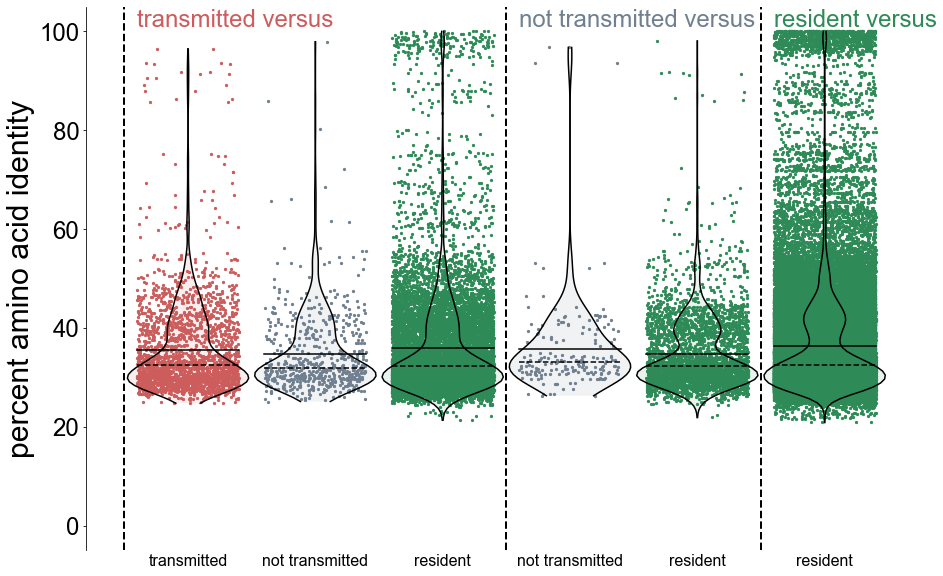

In [4]:
from scipy.stats import gaussian_kde

colours={'transmitted': 'indianred','not transmitted': 'slategrey','resident': 'seagreen'}
categories=['transmitted','not transmitted','resident']

comparisons={a: {b: [] for b in categories} for a in categories}

for vir in transmission_pairs:
    
    if vir in ['Alphas','Betas','Gammas']:
        print(vir)
        distr={}
        count=0

        labels=[]
        store_label=''
        for pair in [(a,b) for a in categories for b in categories if categories.index(a)<=categories.index(b)]:
            type1,type2=pair
            print(pair)
            for sample in transmission_pairs[vir]:
                for A in transmission_pairs[vir][sample][type1]:
                    for B in transmission_pairs[vir][sample][type2]:
                        if A!=B:
                            comparisons[type1][type2].append(distance_matrices[vir][A][B])

fig = plt.figure(figsize=(15, 10),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.1) 
ax=plt.subplot(gs[0],facecolor='w')

count=0
store_label=''
for pair in [(a,b) for a in categories for b in categories if categories.index(a)<=categories.index(b)]:
    type1,type2=pair
    print('plotting %s'%('-'.join(pair)))
    
    kde_fc=colours[type2]
    label_fc=colours[type1]
    labels.append('%s'%(type2))
    kde=gaussian_kde(comparisons[type1][type2])
    x_grid=np.linspace(min(comparisons[type1][type2]),max(comparisons[type1][type2]),100)
    ys=kde(x_grid)
    ys=ys/ys.max()/2.1
    
    ax.fill_betweenx(x_grid,[count-y for y in ys],[count+y for y in ys],facecolor=kde_fc,alpha=0.1,zorder=9)
    ax.plot([count-y for y in ys],x_grid,color='k',zorder=10)
    ax.plot([count+y for y in ys],x_grid,color='k',zorder=10)

    if store_label!=type1:
        ax.axvline(count-0.5,color='k',lw=2,ls='--')
        ax.text(count-0.4,100.0,'%s versus'%(type1),size=24,ha='left',va='bottom',color=label_fc)
    
    xs=[count+np.random.uniform(-0.4,0.4) for c in comparisons[type1][type2]]

    ax.scatter(xs,comparisons[type1][type2],s=5,facecolor=kde_fc,alpha=1.0,zorder=1)
    
    mean=np.mean(comparisons[type1][type2])
    median=np.median(comparisons[type1][type2])
    print(type1,type2,median)
    ax.plot([count-0.4,count+0.4],[mean,mean],color='k',zorder=1000)
    ax.plot([count-0.4,count+0.4],[median,median],color='k',ls='--',zorder=1000)

    count+=1
    store_label=type1

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['left']]
ax.set_ylabel('percent amino acid identity',size=30)
ax.tick_params(axis='x',size=0,labelsize=24)
ax.tick_params(axis='y',labelsize=24)

ax.set_xticks(range(count))
ax.set_xticklabels(labels,size=16)

ax.set_ylim(-5,105)

plt.savefig(os.path.join(base_path, 'figures', 'figure_3B.pdf'),dpi=300,bbox_inches='tight')
plt.show()

not transmitted not transmitted 3 3 ('not transmitted', 'not transmitted')
resident resident 5 2 ('resident', 'resident')
[1.0, 3.5, 5.0]


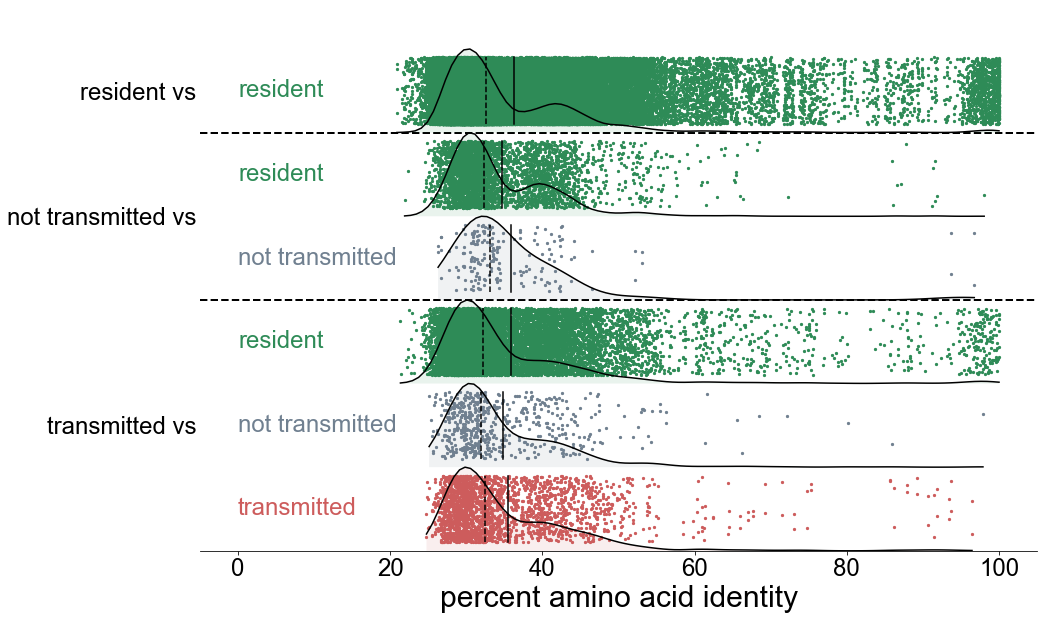

In [4]:
from scipy.stats import gaussian_kde

colours={'transmitted': 'indianred','not transmitted': 'slategrey','resident': 'seagreen'}
categories=['transmitted','not transmitted','resident']

fig = plt.figure(figsize=(15, 10),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.1) 
ax=plt.subplot(gs[0],facecolor='w')

increment=0
count=0
store_label=''
ypos=[]
ylabels=[]

for p,pair in enumerate([(a,b) for a in categories for b in categories if categories.index(a)<=categories.index(b)]):
    type1,type2=pair
    
    kde_fc=colours[type2]
    label_fc=colours[type1]
    labels.append('%s vs'%(type2))
    kde=gaussian_kde(comparisons[type1][type2])
    x_grid=np.linspace(min(comparisons[type1][type2]),max(comparisons[type1][type2]),100)
    ys=kde(x_grid)
    w=1.0
    ys=ys/ys.max()/w
    
    ax.fill_between(x_grid,[w*count-0.5 for y in ys],[w*count+y-0.5 for y in ys],facecolor=kde_fc,alpha=0.1,zorder=9)
    ax.plot(x_grid,[w*count+y-0.5 for y in ys],color='k',zorder=10)
        
    xs=[w*count+np.random.uniform(-0.4,0.4) for c in comparisons[type1][type2]]
    ax.scatter(comparisons[type1][type2],xs,s=5,facecolor=kde_fc,alpha=1.0,zorder=1)
    
    mean=np.mean(comparisons[type1][type2])
    median=np.median(comparisons[type1][type2])
    
    ax.plot([mean,mean],[w*count-0.4,w*count+0.4],color='k',zorder=1000)
    ax.plot([median,median],[w*count-0.4,w*count+0.4],color='k',ls='--',zorder=1000)
    
    ax.text(0.0,w*count,'%s'%(type2),size=24,ha='left',va='center',color=kde_fc)
    
    if (store_label!=type1) and store_label!='':
        ax.axhline(w*count-0.5,color='k',lw=2,ls='--')
        print(type1,type2,count,increment,pair)
        ypos.append(w*count-increment/2-0.5)
        ylabels.append('%s vs'%(store_label))
        increment=0
    if pair==('resident','resident'):
        ypos.append(w*count)
        ylabels.append('%s vs'%(type1))
    
    increment+=1
    count+=1
    
    store_label=type1

print(ypos)
ax.set_yticks(ypos)
ax.set_yticklabels(ylabels,size=16)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_xlabel('percent amino acid identity',size=30)
ax.tick_params(axis='y',size=0,labelsize=24)
ax.tick_params(axis='x',labelsize=24)

ax.set_xlim(-5,105)
ax.set_ylim(-0.5,count)
plt.show()

In [5]:
for vir in transmission_pairs:
    
    if vir in ['Alphas','Betas','Gammas']:
        print(vir)
        distr={}
        count=0

        labels=[]
        store_label=''
        for pair in [(a,b) for a in categories for b in categories if categories.index(a)<=categories.index(b)]:
            type1,type2=pair
            
            if type1=='transmitted' and type2=='resident':
                print(pair)
                for sample in transmission_pairs[vir]:

                    for A in transmission_pairs[vir][sample][type1]:
                        for B in transmission_pairs[vir][sample][type2]:
                            if A!=B and distance_matrices[vir][A][B]>=80.0:
                                print('%s\t%s\t%s'%(A,B,distance_matrices[vir][A][B]))


Alphas
('transmitted', 'resident')
R04D01_20190410_VL46-0475_multiplex_nextseq|NODE_17_length_2938_cov_3457.122095|TTV_Clade5	R04T02-TTVRCA_S4_20190128_VL46-0348_R04T02-R04T04_iseq|NODE_13_length_2969_cov_266.267330|TTV_Clade3	85.5
R04D01_20190529_VL46-0475_multiplex_NextSeq|NODE_28_length_2871_cov_5.142756|TTV_Clade3	R04T01_20190410_VL46-0475_multiplex_nextseq|NODE_35_length_2947_cov_9378.502766|TTV_Clade3	99.31
R04D01_20190529_VL46-0475_multiplex_NextSeq|NODE_28_length_2871_cov_5.142756|TTV_Clade3	R04T01-TTVRCA_S2_20190123_VL46-0348_R04T01_iseq|NODE_19_length_2947_cov_1487.632089|TTV_Clade3	99.59
R04D01_20190529_VL46-0475_multiplex_NextSeq|NODE_9_length_2980_cov_25562.162051|TTV_Clade5	R04T02-TTVRCA_S4_20190128_VL46-0348_R04T02-R04T04_iseq|NODE_16_length_2937_cov_67.503817|TTV_Clade5	94.56
R04D01-TTVRCA_S5_20190125_VL46-0348_R04T00-R04D02_iseq|NODE_8_length_3078_cov_110.565002|TTV_Clade4	R04T01-TTVRCA_S2_20190123_VL46-0348_R04T01_iseq|NODE_13_length_3015_cov_8.404392|TTV_Clade4	89.74